# MONITOREO: VOLATILIDAD
Controlar la evolución de la volatilidad. Utiliza medias móviles de volatilidad y analiza cruces al alza y a la baja. También es importante analizar la volatilidad para ver el tipo de bot a utilizar. Ej.: si estamos temerosos y necesitamos seguridad porque vemos mucha volatilidad en el mercado, asignarle más capital a un bot defensivo cuyo objetivo sea bajar el riesgo de exposición al mercado.). Entonces según eso vamos graduando la exposición al riesgo (y el capital asignado a acciones u estrategias defensivas, etc.). Para controlar la volatilidad/riesgo de los activos y para los loteros.

## ÍNDICE DE FUNCIONES:
 - plotPriceVolat(symbol, desde, hasta, n = 20): Esta función grafica precio y volatilidad de un ticker en particular entre dos fechas especificadas;
 - plotVolat(symbol, desde, hasta, n_fast = 10, n_slow = 20): Esta función plotea dos curvas de volatilidad, una rápida y una lenta y evalúa cruces para determinar zonas de elevada volatilidad y zonas de baja volatilidad. Permite parametrizar la ventana de n ruedas tomadas para cada curva. Las curvas funcionan como medias móviles y la diferencia entre las mismas es representada por un gráfico de barras como un oscilador. Se toma market data desde hasta parametrizable.
 - plotVolatNow(symbol, n_fast = 10, n_slow = 20, period = "1y"): Esta función plotea dos curvas de volatilidad, una rápida y una lenta y evalúa cruces para determinar zonas de elevada volatilidad y zonas de baja volatilidad. Permite parametrizar la ventana de n ruedas tomadas para cada curva. Las curvas funcionan como medias móviles y la diferencia entre las mismas es representada por un gráfico de barras como un oscilador. Se toma el último año de data, hasta hoy.
 

In [1]:
# FUNCIONES NECESARIAS PARA OBTENER DATA FINANCIERA:

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

def getDataYf(ticker, tipo, interval, data_from = None, data_to = None, period = None):
    """
    Es una función para descargar market data de Yahoo Finance con la librería yfinance.
    
    ## Inputs:
        >ticker: el nombre del ticker.
        >tipo: si es "no end" no se indica hasta cuándo (data_to), se obtiene hasta el último día disponible. Si es "end" es
        necesario indicar hasta cuánto (data_to). En ambos casos hay que indicar desde qué fecha (data_from). Si es "period" 
        no se indica ni desde cuándo ni hasta cuándo, sólo el argumento "period" con la cantidad de tiempo a obtener.
        >now : si es True, no se indica hasta cuándo (data_to), se obtiene hasta el último día disponible. Si se indica False, es
        necesario indicar hasta cuánto (data_to).
        >interval: el timeframe (ej. 1mo, 1h, 1d, 1wk, etc)
        >data_from: data desde qué fecha.
        >data_to: data hasta qué fecha (no inclusive el día). Sólo es aplicable si now == True.
        >period : en caso de tipo = "period", se pasa este argumento que refiere a la cantidad de tiempo a obtener. Ej. 1y, 2y, 3y, etc.
        
    ## Outputs:
        >series OHLC ajustadas del ticker.
    """
    import yfinance as yf
    import pandas as pd
    
    if tipo == "no end":
        data = yf.download(ticker, start = data_from, interval = interval, progress = False, auto_adjust = True)
    elif tipo == "end":
        data = yf.download(ticker, start = data_from, end = data_to, interval = interval, progress = False, auto_adjust = True)
    elif tipo == "period":
        data = yf.download(ticker, interval = interval, period = period, progress = False, auto_adjust = True)
    return data



def getDataYfMulti(activos, tipo, interval, data_from = None, data_to = None, period = None, swap = True):
    """
    Función para hacer batch requests (varios tickers a la vez), que será la fx que más voy a utilizar para market data.
    
    ## Inputs:
        >tickers: es una lista con los tickers de los cuales se va a obtener market data.
        >tipo: si es "no end" no se indica hasta cuándo (data_to), se obtiene hasta el último día disponible. Si es "end" es
        necesario indicar hasta cuánto (data_to). En ambos casos hay que indicar desde qué fecha (data_from). Si es "period" 
        no se indica ni desde cuándo ni hasta cuándo, sólo el argumento "period" con la cantidad de tiempo a obtener.
        >now : si es True, no se indica hasta cuándo (data_to), se obtiene hasta el último día disponible. Si se indica False, es
        necesario indicar hasta cuánto (data_to).
        >interval: el timeframe (ej. 1mo, 1h, 1d, 1wk, etc)
        >data_from: data desde qué fecha.
        >data_to: data hasta qué fecha (no inclusive el día). Sólo es aplicable si now == True.
        >period : en caso de tipo = "period", se pasa este argumento que refiere a la cantidad de tiempo a obtener. Ej. 1y, 2y, 3y, etc.
        >swap : si es True, divide el df en tickers y cada uno tiene su OHLC. Si es False, tenemos cada columna OHLC y dentro todos los tickers.
        
    ## Outputs:
        >series OHLC ajustadas del ticker.
    """
    import yfinance as yf
    import pandas as pd
    
    lideres_arg = ["ALUA.BA", "BBAR.BA", "BMA.BA", "BYMA.BA", "CEPU.BA", "COME.BA", "CRES.BA", "CVH.BA", "EDN.BA", 
                   "GGAL.BA", "LOMA.BA", "MIRG.BA", "PAMP.BA", "SUPV.BA", "TECO2.BA", "TGNO4.BA", "TGSU2.BA", "TRAN.BA", 
                   "TXAR.BA", "VALO.BA", "YPFD.BA"]

    general_arg = ["AGRO.BA", "AUSO.BA", "BHIP.BA", "BOLT.BA", "BPAT.BA", "CADO.BA", "CAPX.BA", "CARC.BA", "CECO2.BA", 
                   "CELU.BA", "CGPA2.BA", "CTIO.BA", "DGCU2.BA", "FERR.BA", "FIPL.BA", "GAMI.BA", "GCDI.BA", "GCLA.BA", 
                   "HARG.BA", "HAVA.BA", "INVJ.BA", "IRSA.BA", "LEDE.BA", "LONG.BA", "METR.BA", "MOLA.BA", "MOLI.BA", 
                   "MORI.BA", "OEST.BA", "PATA.BA", "RICH.BA", "RIGO.BA", "SAMI.BA", "SEMI.BA"]

    cedears = ["AAL", "AAPL", "ABBV", "ABEV", "ABNB", "ABT", "ADBE", "ADGO", "ADI", "ADP", "AEM", "AIG", "AMAT", "AMD", 
               "AMGN", "AMZN", "AOCA", "ARCO", "ARKK", "ASR", "AUY", "AVGO", "AXP", "AZN", "BA", "BA.C", "BABA", "BB", 
               "BBD", "BBV", "BCS", "BHP", "BIDU", "BIIB", "BIOX", "BITF", "BK", "BMY", "BNG", "BP", "BRFS", "BRKB", "BSBR", 
               "C", "CAAP", "CAH", "CAR", "CAT", "CBRD", "CDE", "CL", "COIN", "COST", "CRM", "CS", "CSCO", "CVX", "CX", "DD", 
               "DE", "DESP", "DIA", "DISN", "DOCU", "DOW", "E", "EA", "EBAY", "EEM", "EFX", "ERIC", "ERJ", "ETSY", "EWZ", "F", 
               "FCX", "FDX", "FMX", "FSLR", "GE", "GFI", "GGB", "GILD", "GLOB", "GLW", "GM", "GOLD", "GOOGL", "GPRK", "GRMN", 
               "GS", "HAL", "HD", "HL", "HMC", "HMY", "HOG", "HON", "HPQ", "HSBC", "HSY", "HUT", "HWM", "IBM", "IFF", "INTC", 
               "ITUB", "IWM", "JD", "JMIA", "JNJ", "JPM", "KMB", "KO", "KOFM", "LLY", "LMT", "LRCX", "LVS", "LYG", "MA", "MCD", 
               "MDT", "MELI", "META", "MMM", "MO", "MOS", "MRK", "MSFT", "MSI", "MSTR", "MU", "NEM", "NFLX", "NGG", "NIO", "NKE", 
               "NOKA", "NTCO", "NTES", "NUE", "NVDA", "NVS", "ORAN", "ORCL", "OXY", "PAAS", "PAC", "PANW", "PBI", "PBR", "PCAR", 
               "PEP", "PFE", "PG", "PHG", "PKS", "PSX", "PYPL", "QCOM", "QQQ", "RBLX", "RIO", "RTX", "SAN", "SAP", "SATL", "SBUX", 
               "SCCO", "SE", "SHEL", "SHOP", "SI", "SID", "SLB", "SNAP", "SNOW", "SONY", "SPGI", "SPOT", "SPY", "SQ", "SYY", "T", 
               "TEFO", "TEN", "TGT", "TM", "TMO", "TRIP", "TRVV", "TSLA", "TSM", "TTE", "TV", "TWLO", "TXN", "TXR", "UAL", "UBER", 
               "UGP", "UL", "UNH", "UNP", "UPST", "USB", "V", "VALE", "VIST", "VIV", "VOD", "VZ", "WBA", "WFC", "WMT", "X", "XLE", 
               "XLF", "XOM", "XP", "YY", "ZM"]

    adrs = ["BBAR", "BMA", "CEPU", "CRESY", "EDN", "GGAL", "IRS", "LOMA", "PAM", "SUPV", "TEO", "TGS", "TS", "TX", "YPF"]

    sectors = ["XLC", "XLP", "XLY", "XLF", "XLV", "XLI", "XLRE", "XLU", "XBI", "XLB", "XLK", "XLE"]
    
    precarga = ["lideres", "general", "cedears", "adrs", "sectores"]
    precarga_dict = {"lideres" : lideres_arg, "general" : general_arg, "cedears" : cedears, "adrs" : adrs, "sectores" : sectors}
    
    if activos in precarga:
        activos = precarga_dict[activos]
    
    if tipo == "no end":
        data = yf.download(activos, start = data_from, interval = interval, progress = False, auto_adjust = True)
    elif tipo == "end":
        data = yf.download(activos, start = data_from, end = data_to, interval = interval, progress = False, auto_adjust = True)
    elif tipo == "period":
        data = yf.download(activos, interval = interval, period= period, progress = False, auto_adjust = True)
    
    if swap:
        #data = data.swaplevel(i = 0, j = 1, axis = 1)
        # Algoritmo para procesar el MultipleTicker download de yfinance
        dicto = {}
        low = data["Low"]
        high = data["High"]
        close = data["Close"]
        open = data["Open"]
        volume = data["Volume"]

        tickers = list(data["Close"].columns)

        for ticker in tickers:
            dicto[ticker] = {
                "Open" : open[ticker],
                "High" : high[ticker],
                "Low" : low[ticker],
                "Close" : close[ticker],
                "Volume" : volume[ticker]
            }

            dicto[ticker] = pd.DataFrame(dicto[ticker])
        return dicto
    return data

In [2]:
# FUNCIONALIDADES PRINCIPALES DEL MÓDULO:

def plotPriceVolat(symbol, desde, hasta, n = 20, log = False):
    """
    Esta función grafica precio y volatilidad de un ticker en particular entre dos fechas especificadas"
    # Inputs:
        - symbol: ticker.
        - desde: fecha desde.
        - hasta: fecha hasta.
        - n : número de ruedas para la ventana de volatilidad
        - log: si es True, grafica a escala logarítmica, sino, lineal.
    # Outputs.
        - gráfico de precio y volatilidad en doble eje Y del ticker especificado, para las fechas especificadas.
    """
    
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')
    data = getDataYf(symbol, tipo = "end", interval = "1d", data_from = desde, data_to = hasta)
    data["volatilidad"] = (data["Close"].pct_change().rolling(n).std()*252**0.5)*100   # Volatilidad de las últimas 20 ruedas anualizada %
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(data["Close"], lw=1, color="tab:blue", label="Precio cierre")
    ax2 = ax1.twinx()
    ax2.plot(data["volatilidad"], lw=1.5, ls="--", color="tab:red", label=f"Volatilidad {n}r (anualizada)")
    plt.title(f"[{symbol}] - PRECIO Y VOLATILIDAD ANUALIZADA - {desde} al {hasta}", fontsize = 16)
    ax1.set_ylabel("PRECIO", fontsize=14)
    ax2.set_ylabel(f"% VOLATILIDAD {n} RUEDAS ANUALIZADA", fontsize=14)
    if log:
        ax1.set_yscale("log")
    fig.legend(loc = "upper right", fontsize = 8)
    return plt


def plotVolat(symbol, desde, hasta, n_fast = 10, n_slow = 20):
    """
    Esta función plotea dos curvas de volatilidad, una rápida y una lenta y evalúa cruces para determinar zonas de elevada volatilidad y
    zonas de baja volatilidad. Permite parametrizar la ventana de n ruedas tomadas para cada curva. Las curvas funcionan como medias móviles
    y la diferencia entre las mismas es representada por un gráfico de barras como un oscilador. Se toma market data desde hasta parametrizable.
    
    # Inputs:
        - symbol: ticker del activo;
        - desde: data desde;
        - hasta: data hasta;
        - n_fast: ventana de n ruedas tomadas para calcular la volatilidad "rápida";
        - n_slow: ventana de n ruedas tomadas para calcular la volatilidad "lenta";
    
    # Outputs:
        - plt: los gráficos pertinentes;
        - data: el dataframe con los números de volatilidad anualizada (rápida, lenta y diferencia)
    """
    
    
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')
    
    # Data prepare
    data = getDataYf(symbol, tipo = "end", interval = "1d", data_from = desde, data_to = hasta)
    data["volat_F"] = (data["Close"].pct_change().rolling(n_fast).std()*252**0.5)*100   # Volatilidad de las últimas n_fast ruedas anualizada %
    data["volat_S"] = (data["Close"].pct_change().rolling(n_slow).std()*252**0.5)*100   # Volatilidad de las últimas n_slow ruedas anualizada %
    data["difVolat"] = data["volat_F"] - data["volat_S"]
    data = data.loc[: , ["volat_F", "volat_S", "difVolat"]].dropna().round(2)
    mask_red = data["difVolat"] > 0
    mask_green = data["difVolat"] < 0
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6), nrows = 2, ncols = 1)
    
    
    ax[0].plot(data["volat_F"], lw=1, ls="-", color="tab:red", label=f"Volatilidad {n_fast}r (anualizada)")
    ax[0].plot(data["volat_S"], lw=2, ls="-", color="tab:blue", label=f"Volatilidad {n_slow}r (anualizada)")
    plt.suptitle(f"[{symbol}] - VOLATILIDAD ANUALIZADA - FAST{n_fast} y SLOW{n_slow} - {desde} al {hasta}", fontsize = 16)
    ax[1].bar(data[mask_red].index, data[mask_red]["difVolat"], color = "tab:red")
    ax[1].bar(data[mask_green].index, data[mask_green]["difVolat"], color = "tab:green")
    
    fig.legend(loc = "center", fontsize = 8)
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.close()
    return fig, data
                 
def plotVolatNow(symbol, n_fast = 10, n_slow = 20, period = "1y"):
    """
    Esta función plotea dos curvas de volatilidad, una rápida y una lenta y evalúa cruces para determinar zonas de elevada volatilidad y
    zonas de baja volatilidad. Permite parametrizar la ventana de n ruedas tomadas para cada curva. Las curvas funcionan como medias móviles
    y la diferencia entre las mismas es representada por un gráfico de barras como un oscilador. Se toma el último año de data, hasta hoy.
    
    # Inputs:
        - symbol: ticker del activo;
        - n_fast: ventana de n ruedas tomadas para calcular la volatilidad "rápida";
        - n_slow: ventana de n ruedas tomadas para calcular la volatilidad "lenta";
    
    # Outputs:
        - plt: los gráficos pertinentes;
        - data: el dataframe con los números de volatilidad anualizada (rápida, lenta y diferencia)
    """
    
    
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')
    
    # Data prepare
    data = getDataYf(symbol, tipo = "period", interval = "1d", period = period)
    data["volat_F"] = (data["Close"].pct_change().rolling(n_fast).std()*252**0.5)*100   # Volatilidad de las últimas n_fast ruedas anualizada %
    data["volat_S"] = (data["Close"].pct_change().rolling(n_slow).std()*252**0.5)*100   # Volatilidad de las últimas n_slow ruedas anualizada %
    data["difVolat"] = data["volat_F"] - data["volat_S"]
    data = data.loc[: , ["volat_F", "volat_S", "difVolat"]].dropna().round(2)
    mask_red = data["difVolat"] > 0
    mask_green = data["difVolat"] < 0
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6), nrows = 2, ncols = 1)
    plt.suptitle(f"[{symbol}] - VOLATILIDAD ANUALIZADA - FAST{n_fast} y SLOW{n_slow} - últimos {int(round(len(data)/30,0)*2)} meses", fontsize = 16)
    
    ax[0].plot(data["volat_F"], lw=1, ls="-", color="tab:red", label=f"Volatilidad {n_fast}r (anualizada)")
    ax[0].plot(data["volat_S"], lw=2, ls="-", color="tab:blue", label=f"Volatilidad {n_slow}r (anualizada)")
    
    
    ax[1].bar(data[mask_red].index, data[mask_red]["difVolat"], color = "tab:red")
    ax[1].bar(data[mask_green].index, data[mask_green]["difVolat"], color = "tab:green")
    fig.legend(loc = "center", fontsize = 8)
    plt.close()
    
    #plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    return fig, data   


<module 'matplotlib.pyplot' from 'C:\\Users\\user\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

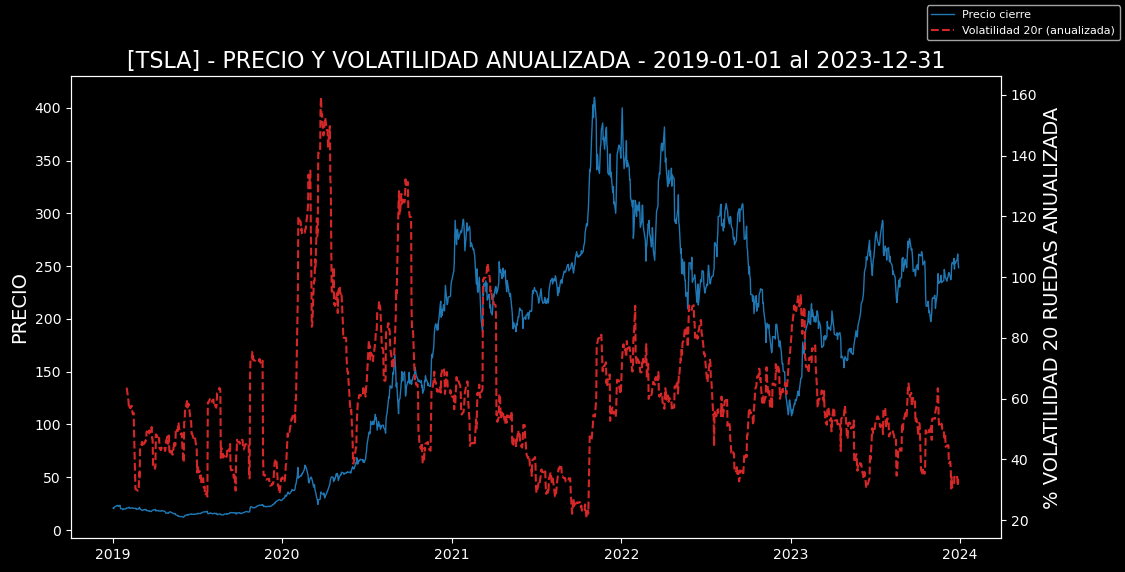

In [5]:
# Ploteamos volatilidad anualizada de las últimas 20 ruedas, 2019 a 2023 - activo TSLA
plotPriceVolat("TSLA", "2019-01-01", "2023-12-31", n = 20)

In [8]:
grafico, tabla = plotVolat("TSLA", "2023-01-01", "2023-12-31", n_fast = 10, n_slow = 20)

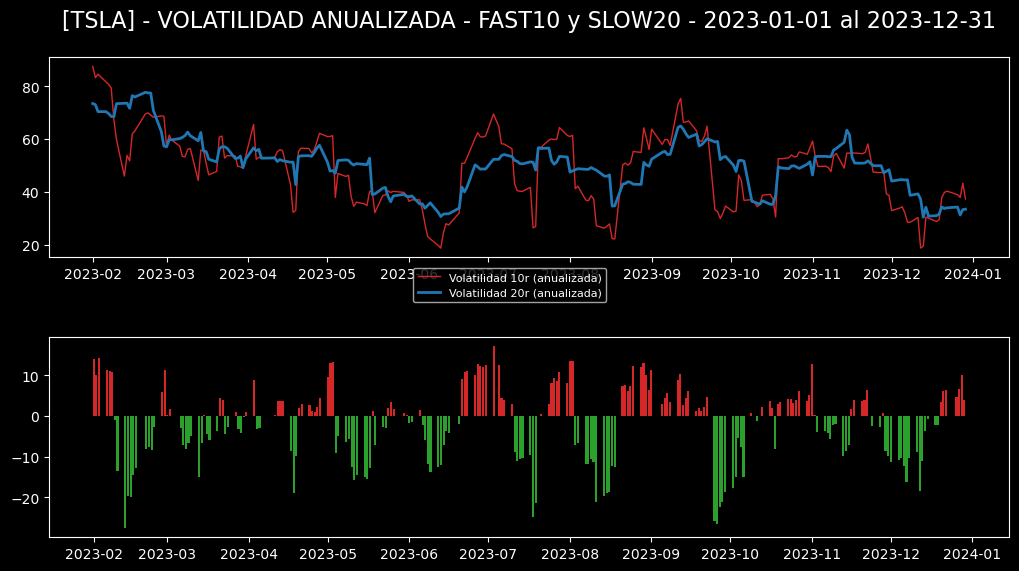

In [9]:
# plotVolat - output - grafico
grafico

<module 'matplotlib.pyplot' from 'C:\\Users\\user\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

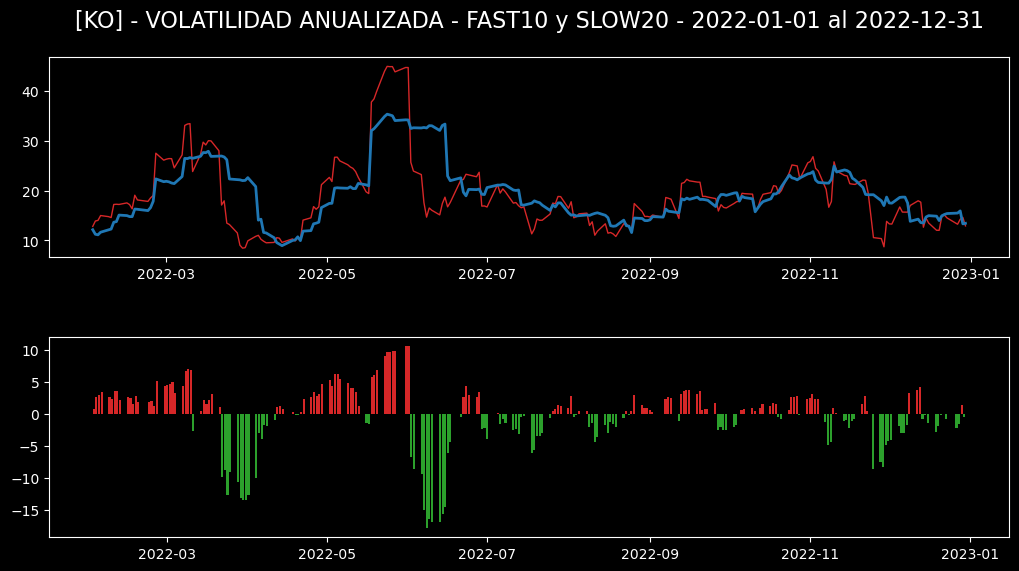

In [19]:
plotVolat("KO", "2022-01-01", "2022-12-31", n_fast = 10, n_slow = 20)[0]

In [10]:
grafico, tabla = plotVolatNow("TSLA", n_fast = 10, n_slow = 30, period = "6mo")

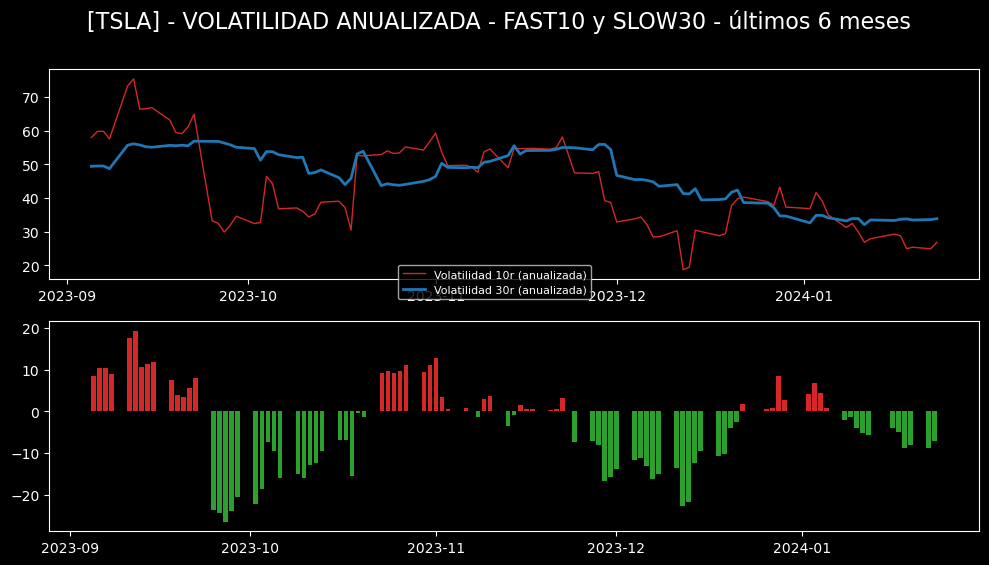

In [11]:
# plotVolatNow - output - grafico
grafico

In [12]:
# plotVolatNow - output - tabla
tabla

,volat_F,volat_S,difVolat
Date,,,
2023-09-05,57.99,49.42,8.57
2023-09-06,59.79,49.52,10.27
2023-09-07,59.83,49.52,10.31
2023-09-08,57.58,48.73,8.86
2023-09-11,73.28,55.69,17.59
...,...,...,...
2024-01-17,28.76,33.71,-4.95
2024-01-18,24.96,33.81,-8.86
2024-01-19,25.41,33.48,-8.07
